# Chicago Crime Data

In [1]:
from datetime import datetime
import matplotlib.pylab as plt
from sodapy import Socrata
from pandas import DataFrame,to_datetime
from bokeh.io import show, output_notebook
from bokeh.plotting import figure,ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import Spectral11,Category20
from math import pi

output_notebook()
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 10.0)
tools_to_show = 'hover,box_zoom,pan,save,reset,wheel_zoom'

# Use the sodapy API to grab the chicago crime data
soda_client = Socrata("data.cityofchicago.org", None)
chicago_crime_endpoint ="6zsd-86xi"

def build_socrata_date_between(date1 ,date2):
    """Converts from datetime to socrata string readable format"""
    urlStringFormat = "%Y-%m-%dT%H:%M:00"
    return( "date between '" + date1.strftime(urlStringFormat) + \
                "' and '"+ date2.strftime(urlStringFormat) + "'")

Loading BokehJS ...

# Let's look at all the monthly data on the City of Chicago Website

In [2]:
monthly_data = soda_client.get(chicago_crime_endpoint,
                               select="date_trunc_ym(date) AS month,count(*) AS total",
                               group="month")

results_df = DataFrame.from_records(monthly_data)
p = figure(plot_width=900,
           plot_height=500,
           x_axis_type='datetime',
           y_axis_label = "Total Monthly Crimes Reported",
           title="Monthly Crime Rate of Chicago Over Time",
           tools=tools_to_show)

source = ColumnDataSource(data={
                'date': results_df['month'].apply(to_datetime),
                'crime': results_df.total,
            })

p.line('date', 'crime', source=source, line_width=2)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [("Total Crimes", "@crime"),("Date", "@date{%F}")]
hover.formatters={'date': 'datetime'}
hover.mode = "vline"
show(p)

In [3]:
types_of_crimes = soda_client.get("6zsd-86xi",select="primary_type AS crime_type,count(*) AS total",group="crime_type")
list_crimes = [i['crime_type'] for i in types_of_crimes]
freq = [int(i['total']) for i in types_of_crimes]

p = figure(x_range=list_crimes,
           plot_width=900,
           plot_height=700,
           title="Frequency of Chicago Crime",
           tools=tools_to_show)
p.vbar(x=list_crimes, top=freq, width=0.9)
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = pi/2
hover = p.select(dict(type=HoverTool))
hover.tooltips = [("Total", "$y{0,0}")]
show(p)

In [6]:
def grab_socrata_crimes(soda_client,
                        list_crimes,
                        chicago_crime_endpoint="6zsd-86xi",
                        start_date=datetime(2016,1,12),
                        end_date=datetime(2018,1,12)):
    """Download socrata data
    
    Keyword arguments:
    soda_client -- client for connecting to socrata (default 0.0)
    list_crimes -- list of crime to grab (e.g. [ARSON, ASSAULT,...])
    chicago_crime_endpoint -- endpoint for chicago crimes (default "6zsd-86xi")
    start_date -- datetime start date (default Jan. 1, 2016)
    end_date -- datetime end date (default Jan. 1, 2018)
    """
    
    soda_data = soda_client.get(chicago_crime_endpoint,
                                limit=99999999999,
                                where=build_socrata_date_between(start_date,end_date) + \
                                " AND primary_type in " + str(tuple(map(str, list_crimes))))
    results_df = DataFrame.from_records(soda_data)
    results_df['date'] = results_df['date'].apply(to_datetime)
    results_df['latitude'] = results_df['latitude'].astype(float)
    results_df['longitude'] = results_df['longitude'].astype(float)
    results_df = results_df.set_index("date")
    return results_df

In [7]:
chicago_crime_df = grab_socrata_crimes(soda_client, list_crimes)
print(len(chicago_crime_df))
chicago_crime_df.head()

533368


arrest  beat                block case_number  \
date                                                                 
2016-04-18 22:30:00   False  0512  104XX S CORLISS AVE    HZ231785   
2016-04-21 00:01:00   False  0811    056XX S NAGLE AVE    HZ234588   
2016-04-22 09:00:00   False  0231  056XX S PRAIRIE AVE    HZ236193   
2016-01-26 15:00:00   False  0814    045XX S LAMON AVE    HZ243545   
2017-01-19 18:28:15    True  0824  059XX S ROCKWELL ST    JA122203   

                    community_area     description district  domestic  \
date                                                                    
2016-04-18 22:30:00             50  $500 AND UNDER      005     False   
2016-04-21 00:01:00             56       OVER $500      008     False   
2016-04-22 09:00:00             40  $500 AND UNDER      002     False   
2016-01-26 15:00:00             56          SIMPLE      008      True   
2017-01-19 18:28:15             66   POSS: COCAINE      008     False   

                    fbi_code        id  ...  latitude  location  \
date                                    ...                       
2016-04-18 22:30:00       06  10491241  ...       NaN       NaN   
2016-04-21 00:01:00       06  10493993  ...       NaN       NaN   
2016-04-22 09:00:00       06  10495942  ...       NaN       NaN   
2016-01-26 15:00:00      08A  10502795  ...       NaN       NaN   
2017-01-19 18:28:15       18  10842630  ...       NaN       NaN   

                    location_description longitude  primary_type  \
date                                                               
2016-04-18 22:30:00               STREET       NaN         THEFT   
2016-04-21 00:01:00               STREET       NaN         THEFT   
2016-04-22 09:00:00            RESIDENCE       NaN         THEFT   
2016-01-26 15:00:00            RESIDENCE       NaN       ASSAULT   
2017-01-19 18:28:15            APARTMENT       NaN     NARCOTICS   

                                  updated_on ward x_coordinate y_coordinate  \
date                                                                          
2016-04-18 22:30:00  2016-04-25T15:51:07.000    9          NaN          NaN   
2016-04-21 00:01:00  2016-04-28T15:51:26.000   23          NaN          NaN   
2016-04-22 09:00:00  2016-04-29T15:47:33.000   20          NaN          NaN   
2016-01-26 15:00:00  2016-04-29T15:47:33.000   23          NaN          NaN   
2017-01-19 18:28:15  2017-08-05T15:50:08.000   16          NaN          NaN   

                     year  
date                       
2016-04-18 22:30:00  2016  
2016-04-21 00:01:00  2016  
2016-04-22 09:00:00  2016  
2016-01-26 15:00:00  2016  
2017-01-19 18:28:15  2017  

[5 rows x 21 columns]

In [8]:
TotalMonthlyCrimeData = chicago_crime_df.arrest.resample(rule='D').apply(len)

p = figure(plot_width=900,
           plot_height=500,
           x_axis_type='datetime',
           y_axis_label = "Total Crimes Reported",
           title="Daily Crime Rate of Chicago Between Jan 1. 2016 - Jan 1. 2018",
           tools=tools_to_show)

source = ColumnDataSource(data={
                'date': TotalMonthlyCrimeData.index, # python datetime object as X axis
                'crime': TotalMonthlyCrimeData.values,
            })

p.line('date', 'crime', source=source, line_width=2)

hover = p.select(dict(type=HoverTool))
hover.formatters={'Total Crimes' : 'printf','date': 'datetime'}
hover.tooltips = [("Total Crimes", "@crime"),("Date", "@date{%F}")]
hover.mode = "vline"

show(p)

In [9]:
MonthlyArrestedCrimes = chicago_crime_df.groupby(['arrest']).arrest.resample(rule='D').apply(len).unstack(level=0)

MonthlyArrestedCrimes.columns=["true","false"]

p = figure(plot_width=900,
           plot_height=500,
           x_axis_type='datetime',
           title="Breakdown Per Day",
           y_axis_label = "Total Daily Stops",
           tools=tools_to_show)

for index,col in enumerate(MonthlyArrestedCrimes.columns):

    source = ColumnDataSource(data={
                    'date': MonthlyArrestedCrimes.index, # python datetime object as X axis
                    'crime': MonthlyArrestedCrimes[col].values,
                    'arrested': [col for i in MonthlyArrestedCrimes[col].values],
                })

    p.line('date', 'crime', source=source, color = Spectral11[index], line_width=2)

hover = p.select(dict(type=HoverTool))

hover.tooltips = [("Number of Crimes", "@crime"),("Arrested", "@arrested")]
hover.mode = "vline"

show(p)

In [10]:
AllDailyData=chicago_crime_df.groupby(['primary_type']).arrest.resample('D').apply(len).unstack(level=0)

p = figure(width=900,
           height=600,
           title="Breakdown Of Daily Crimes",
           y_axis_label = "Daily Crimes Reported",
           x_axis_type="datetime",
           tools=tools_to_show)

for index,name in enumerate(AllDailyData.columns):
    source = ColumnDataSource(data={
                'date': AllDailyData.index.values, # python datetime object as X axis
                'crime': AllDailyData[name].values,
                'name': [name for i in AllDailyData[name].values]
            })
    
    p.line('date', 'crime', source=source, color = Spectral11[index % len(Spectral11)])

# show the tooltip
hover = p.select(dict(type=HoverTool))
hover.tooltips = [("Crime", "@name"),("Total", "@crime"),("Date", "@date{%F}")]
hover.formatters = {'date': 'datetime'}

show(p)

In [11]:
subset_crime_data = chicago_crime_df[(chicago_crime_df.arrest==True) &
                                    (chicago_crime_df.index>to_datetime('01/01/2017')) &
                                    (chicago_crime_df.index<to_datetime('01/01/2018'))].dropna()
    
p = figure(width=900,
           height=600,
           title="Map of Chicago Crimes",
           tools=tools_to_show) 

for index,crime in enumerate(subset_crime_data.primary_type.unique()):
    subset_crime_data.loc[subset_crime_data.primary_type==crime,"color"]=Category20[20][index % -20]

source = ColumnDataSource(dict(
        x=subset_crime_data.longitude,
        y=subset_crime_data.latitude,
        date=subset_crime_data.index.strftime("%Y-%M-%d %h-%m-%s"),
        crime=subset_crime_data["primary_type"],
        location=subset_crime_data["location_description"],
        description=subset_crime_data["description"],
        color=subset_crime_data['color']
    ))

p.circle(x="x", y="y", source=source, color="color",size=3, line_color=None)
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Crime", "@crime"),
    ("Description", "@description"),
    ("Date", "@date"),
    ("Location Description", "@location")
]

show(p)

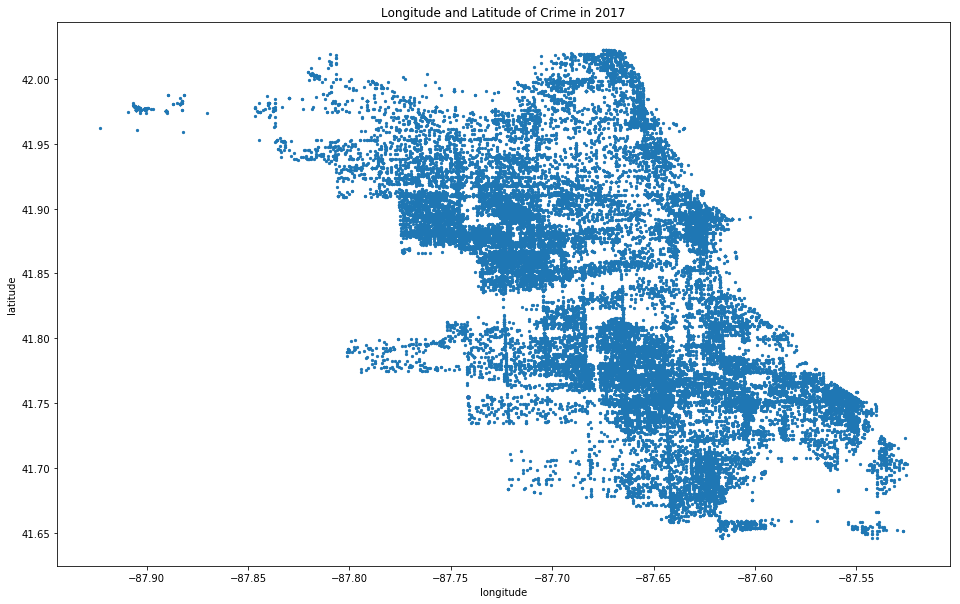

In [12]:
subset_crime_data.plot(kind='scatter',
                      x='longitude',
                      y='latitude',
                      title="Longitude and Latitude of Crime in 2017",
                      alpha=1,
                      marker=".")

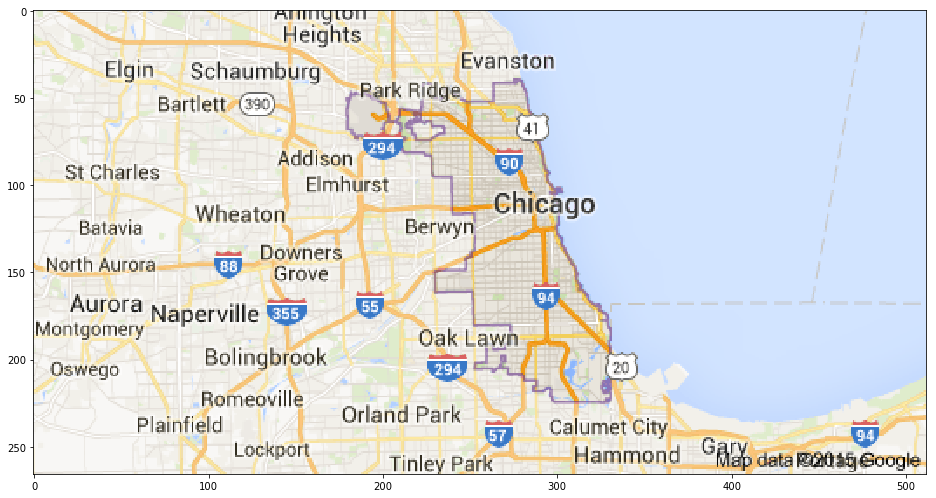

In [13]:
im = plt.imread("images\\ChicagoMap.png")
implot = plt.imshow(im)

In [15]:
chicagoImage = plt.imread("images\\ChicagoMap.png") 
def plotAndOverlay(sampleData, im=chicagoImage, numKMeans=0, centerSizes=0):    
    alpha=.5
    marker="."
    implot = plt.imshow(im, extent=[-88.39,
                                   -87.07,
                                   41.548,
                                   42.112]) 
   
    
    plt.scatter(sampleData['longitude'],
                sampleData['latitude'],
                alpha=alpha,
                marker=marker) 
    
    if(numKMeans>0):
        from sklearn.cluster import KMeans
        from scipy.stats import itemfreq
    
        means = KMeans(numKMeans) 
        pointGroupings = means.fit_predict(sampleData[['longitude','latitude']]) 
        clusterSizes = itemfreq(means.labels_)[:,1] * 4000 / len(means.labels_)
        plt.scatter(sampleData['longitude'],
                    sampleData['latitude'],
                    c=pointGroupings,
                    alpha=alpha,
                    marker=marker)
        if(centerSizes):
            plt.scatter(means.cluster_centers_[:,0],
                        means.cluster_centers_[:,1],
                        s=clusterSizes,
                        color='red',
                        alpha=alpha,
                        marker=marker)
    plt.xlim(-88.01, -87.47)
    plt.ylim(41.568, 42.132)


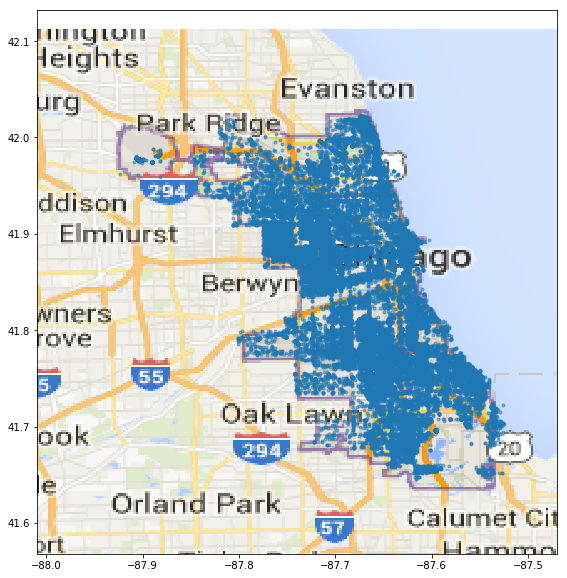

In [16]:
plotAndOverlay(subset_crime_data)

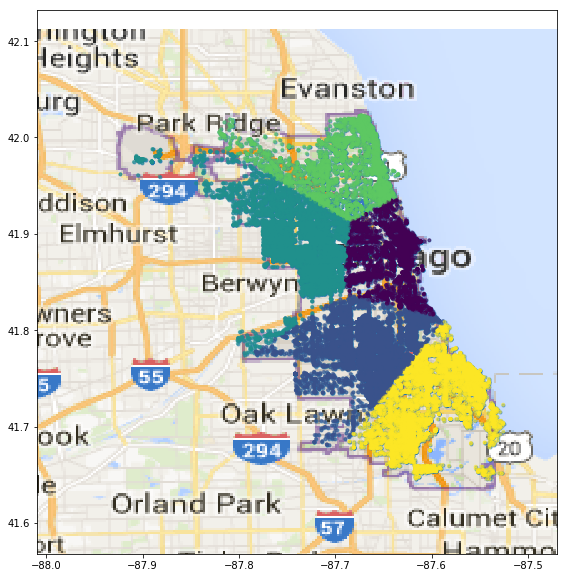

In [17]:
plotAndOverlay(subset_crime_data,numKMeans=5)

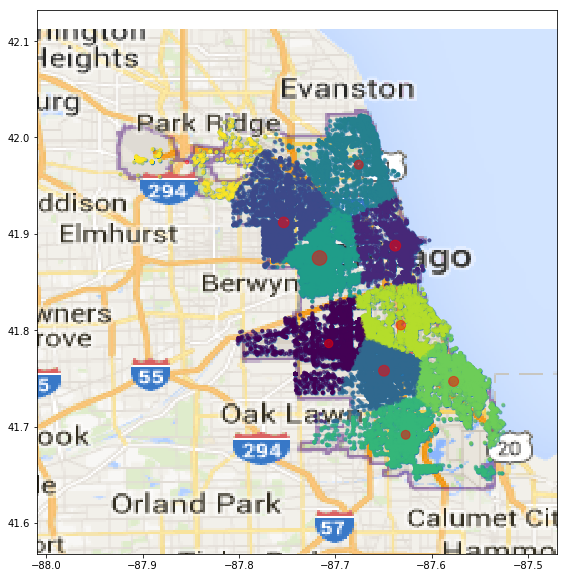

In [18]:
plotAndOverlay(subset_crime_data,numKMeans=10,centerSizes=1)

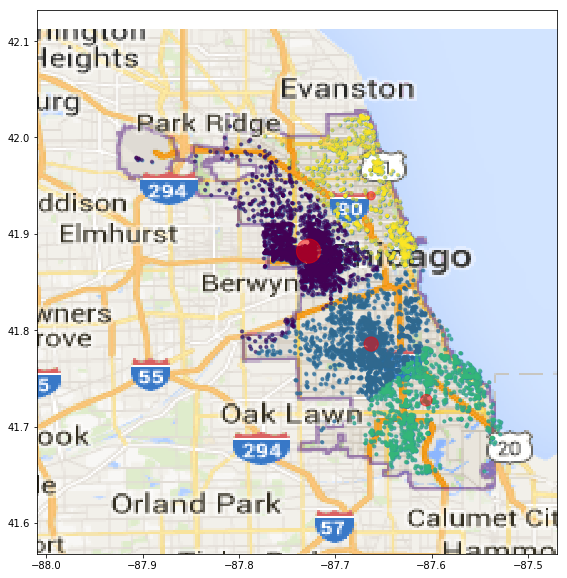

In [19]:
narcotics_crimes = subset_crime_data[(subset_crime_data['primary_type'] == 'NARCOTICS')].dropna()
plotAndOverlay(narcotics_crimes, numKMeans=4, centerSizes=1)

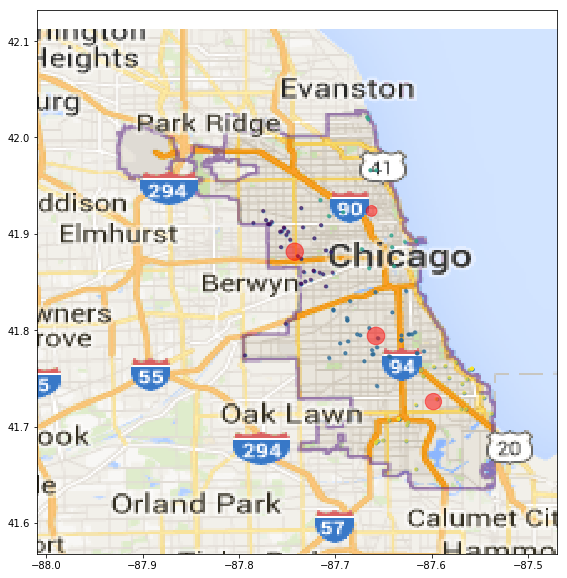

In [20]:
homicides_crimes = subset_crime_data[(subset_crime_data['primary_type'] == 'HOMICIDE')].dropna()
plotAndOverlay(homicides_crimes, numKMeans=4, centerSizes=1)